In [1]:
%matplotlib inline

![![University of Information Technology and Management in Rzeszow, Poland](https://gitlab.wsiz.pl/lgajecki/SA/-/raw/master/wsiz_eng.png)](wsiz_eng.png)

# Laboratory 6  - Deep Networks (CNN, Pooling)

**Datasets** will be used with **DataLoader** to provide data for training. **DataLoader** can build minibatches (portions of data points defined by batch-size) to provide another training (with minibatches) that use of the whole matrix (off line training). Pytorch provide classes of different interesting datasets (such class mostly cause downloading of several hundreds of MB). As well it deliver the base and quite simple clasess for custom datasets (i.e. ImageFolder ) 

[1] Pytorch documentation - torchvision. Datasets https://pytorch.org/vision/main/datasets.html

## 1. Datasets

The data can be organized in classes inherited from torch.utils.Dataset
Below we will do the exercise with our simple example. Later we will use classes provided by Pytorch

Custom dataset has to implement  `__init__`, `__len__` and `__getitem__` methods. 

* `__init__` set the structure of data, for images it might set the folder with images, read annotation file etc. It is called once at beginning.
* `__len__` returns the number of elements
* `__getitem__` returns single vector of data given its index

[2] Pytorch tutorials. Datasets & DataLoaders https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

### 1.1. Example dataset 

In [2]:
from torch.utils.data import Dataset
import torch.utils.data
import numpy as np

import math

class SimpleData(Dataset):
    def __init__(self,n_points):
        self.n=n_points
        
    def __len__(self):
        return self.n
    
    def __getitem__(self,idx):
        x = idx/self.n*2*math.pi
        y1 = math.sin(x)
        y2 = math.cos(x)
        return np.array([x]), np.array([y1,y2])
        
full_dataset = SimpleData(100)        

We will split the data into train, validation and test set

In [3]:
train_size = int(0.4 * len(full_dataset))
validation_size = int(0.3 * len(full_dataset))
test_size = len(full_dataset) - train_size - validation_size

#random_split function split randomly (by shuffling) the given set into some subsets, 
#such many as elements in second parameter
train_data, validation_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, validation_size, test_size])

### 1.2. DataLoader

The DataLoader is class, that can be used later for iterating. Batch is set of given number of data vectors. We call such sets as minibatches. One minibatch provide for one step of training of network. Minibatch should be relatively small (like 8-128) not to exhaust memory especially GPU, since size respective matrices depends of minibatch size  

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

next(iter(train_dataloader)) # on some versions iter(trainloader).next()

[tensor([[2.7646],
         [0.7540],
         [1.2566],
         [3.1416]], dtype=torch.float64),
 tensor([[ 3.6812e-01, -9.2978e-01],
         [ 6.8455e-01,  7.2897e-01],
         [ 9.5106e-01,  3.0902e-01],
         [ 1.2246e-16, -1.0000e+00]], dtype=torch.float64)]

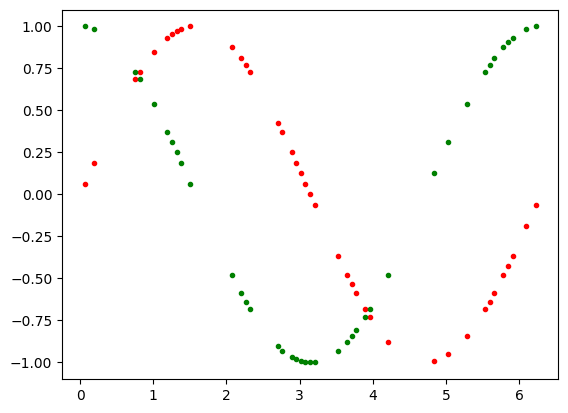

In [5]:
import matplotlib.pyplot as plt
x=torch.empty(0,1)
y=torch.empty(0,2)
for x_,y_ in iter(train_dataloader):
  x=torch.cat((x,x_),0)
  y=torch.cat((y,y_),0)
plt.plot(x.numpy(),y.numpy()[:,0],'r.')
plt.plot(x.numpy(),y.numpy()[:,1],'g.')

### 1.3 Neural Network training

Below we will construct simple neural network. Then we will train using dataset from point 1.1

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(1,2)

  def forward(self,x):
    x=(self.layer1(x))
    return F.relu(x)

net=SimpleNet()

In [7]:
import torch.optim as optim

criterion = nn.MSELoss() #nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)#, momentum=0.9)

In [8]:
def training(net,criterion,optimizer,train_dataloader,validation_dataloader,test_dataloader):

    #for figure only
    train_err=[]
    valid_err=[]
    test_err=[]

    for epoch in range(20):  # loop over the dataset multiple times
        train_err__=0.0
        valid_err__ =0.0
        running_loss = 0.0

        valid_iterator=iter(validation_dataloader)
        for i, data in enumerate(train_dataloader):

            #Training
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            #inputs=torch.Tensor.new_tensor(inputs,dtype=torch.double)
            #torch.tensor(inputs,dtype=torch.double)
            inputs=inputs.float()
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_err__+=running_loss
            print(f'[{epoch + 1}, {i + 1:5d}] training loss: {running_loss:.3f}') # /10 =num minibatches
            running_loss = 0.0
            #if i % 10 == 9:    # print every 10 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #    running_loss = 0.0

            #validation
            with torch.no_grad():
                inputs, labels = next(valid_iterator) # on some versions: inputs, labels = valid_iterator.next()
                outputs = net(inputs.float())
                loss = criterion(outputs, labels)
                valid_err__+=loss.item()
                print(f'[{epoch + 1}, {i + 1:5d}] validation loss: {loss.item() :.3f}')


        train_err.append(train_err__)
        valid_err.append(valid_err__)

        with torch.no_grad():
            running_loss = 0.0
            for data in test_dataloader:
                inputs, labels =data
                outputs = net(inputs.float())
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        test_err.append(running_loss)
        print(f'test loss: {running_loss /len(test_data):.3f}')
    print('Finished Training')
    #print(f'train_err: {train_err}  valid_err:{valid_err} test_err:{test_err}')
    return train_err,valid_err,test_err

In [9]:
train_err,valid_err,test_err=training(net,criterion,optimizer,train_dataloader,validation_dataloader,test_dataloader)

[1,     1] training loss: 0.500
[1,     1] validation loss: 0.500
[1,     2] training loss: 0.500
[1,     2] validation loss: 0.500
[1,     3] training loss: 0.500
[1,     3] validation loss: 0.500
[1,     4] training loss: 0.500
[1,     4] validation loss: 0.500
[1,     5] training loss: 0.500
[1,     5] validation loss: 0.500
[1,     6] training loss: 0.500
[1,     6] validation loss: 0.500
[1,     7] training loss: 0.500
[1,     7] validation loss: 0.500
[1,     8] training loss: 0.500
[1,     8] validation loss: 0.500
[1,     9] training loss: 0.500
[1,     9] validation loss: 0.500
[1,    10] training loss: 0.500
[1,    10] validation loss: 0.500
test loss: 0.500
[2,     1] training loss: 0.500
[2,     1] validation loss: 0.500
[2,     2] training loss: 0.500
[2,     2] validation loss: 0.500
[2,     3] training loss: 0.500
[2,     3] validation loss: 0.500
[2,     4] training loss: 0.500
[2,     4] validation loss: 0.500
[2,     5] training loss: 0.500
[2,     5] validation loss:

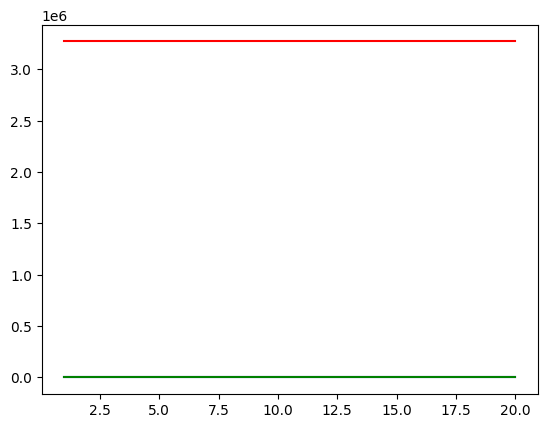

In [10]:
plt.plot(np.arange(1,21),np.exp(np.array(train_err)),'b') #ForCrossEntropyLoss we need to use exp, since it is a logarithm function
plt.plot(np.arange(1,21),np.exp(np.array(valid_err)),'g')
plt.plot(np.arange(1,21),np.exp(np.array(test_err)),'r')

[3]. StackOverflow, How do I split a custom dataset into training and test datasets?  https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

## 2. Convolution Layer

Assuming 1 input channel, 1 output channel, kernel size n=3: the convolution takes as input for output 0,0 the cells in rectangular shape from 0,0: row:0..r-2, column: 0..c-2. Next -for 0,1 the kernel is moving into row: 0..r-1, column 1..c etc. Such inputs are mutiplied by weights and add bias. This is one neuron with 'moving' `rxc` inputs, which give shape 'r-1 x c-1' outputs

When we have `k` **input channels** the above mask is applied in all k input channels, which mean `n x n x k` inputs

`m` **output channels** -each channel is produced separately by one neuron

Rectangular kernel `n1 x n2` can be provided by tupple instead of number:  
  
`Conv2d(1,1,(3,4))`


[3] What are convolutional neural networks? IBM https://www.ibm.com/topics/convolutional-neural-networks

[4] CS231n Convolutional Neural Networks for Visual Recognition, Stanford University https://cs231n.github.io/convolutional-networks/

![![Fig. convolution](https://gitlab.wsiz.pl/lgajecki/SA/-/raw/master/convolution.png)](convolution.png)

In [11]:
m = nn.Conv2d(1, 1, 3) # one input channel, one output channel, kernel size 3-kernel is 3x3
m.weight.data=torch.tensor([[[[-1,0,1],[-1,0,1],[-1,0,1]]]]).float()
m.bias.data=torch.Tensor([0])
print(f'weights: {m.weight.data} \nbias:{m.bias.data}')
inp = torch.randint(low=0,high=10,size=(1,10,10)).float()
out = m(inp)
#print(f'inp ={inp} size:{inp.size()}')
#print(f'out ={out} size:{out.size()}')

weights: tensor([[[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]]) 
bias:tensor([0.])


In [12]:
# Imports for JupyterLite
try:
    import piplite
    await piplite.install(['ipywidgets'])
except ImportError:
    pass

import ipywidgets as widgets



In [13]:
def printTensor3(t,name):
    items = [widgets.Label(f'{t[i,j,k].item():.3f}') for i in range(t.shape[0]) for j in range(t.shape[1]) for k in range(t.shape[2])]
    print(f'{name}.size:{t.size()} {name}= ')
    return widgets.GridBox(items, layout=widgets.Layout(grid_template_columns=f"repeat({t.shape[1]}, 60px)"))

In [14]:
printTensor3(inp,'inp')

inp.size:torch.Size([1, 10, 10]) inp= 


GridBox(children=(Label(value='1.000'), Label(value='1.000'), Label(value='6.000'), Label(value='8.000'), Labe…

In [15]:
printTensor3(out,'out')

out.size:torch.Size([1, 8, 8]) out= 


GridBox(children=(Label(value='5.000'), Label(value='9.000'), Label(value='-2.000'), Label(value='-1.000'), La…

Convolution masks was used before Convolutional Layers. They was fixed.The mask below is responsible for detectingdifferentials-edges -growing brightness from left to right

In [16]:
printTensor3(m.weight.data[0],'m.weight')

m.weight.size:torch.Size([1, 3, 3]) m.weight= 


GridBox(children=(Label(value='-1.000'), Label(value='0.000'), Label(value='1.000'), Label(value='-1.000'), La…

The mask below can smooth image

In [17]:
m_smooth=torch.tensor([[[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]])
printTensor3(m_smooth,'m_smooth')

m_smooth.size:torch.Size([1, 3, 3]) m_smooth= 


GridBox(children=(Label(value='0.111'), Label(value='0.111'), Label(value='0.111'), Label(value='0.111'), Labe…

Below we assign first mask to Convolutional Layer and we will notice what happen at processed image

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms

Loading image from dataset

In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
# Here root defines the directory, where dataset will be saved after downloading
# In server this is location of downloaded dataset be me, so you have access to it
# On your computer root may be "" (or leave as a default)
trainset = torchvision.datasets.CIFAR10(root='/srv/shared_data/data', train=True,
                                        download=True, transform=transform) #on your own machine use root='./data'
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/srv/shared_data/data', train=False,
                                       download=True, transform=transform) #on your own machine use root='./data'
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


weight:torch.Size([1, 3, 3, 3]) bias:torch.Size([1])


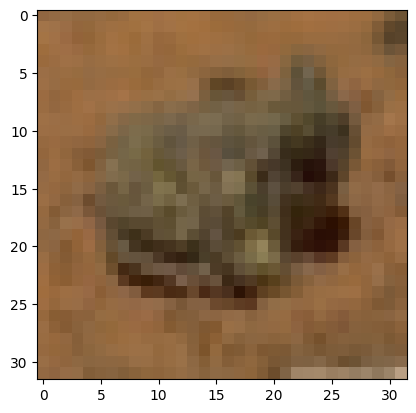

img_out:torch.Size([1, 30, 30])


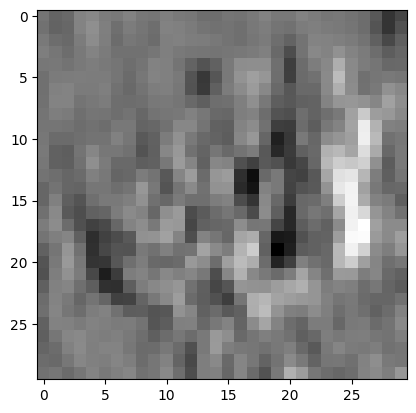

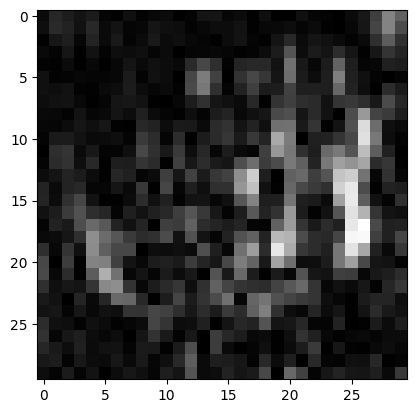

In [20]:
def imshow(img, cmap=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),cmap=cmap)
    plt.show()

#I simplified calculations - one channel out - gives imgaes in colours -dark blue-blue-green-yellow
m2 = nn.Conv2d(3, 1, 3) # three input channel, one output channel, kernel size 3
print(f'weight:{m2.weight.size()} bias:{m2.bias.size()}')
m2.weight.data=torch.tensor([[[[-1,0,1],[-1,0,1],[-1,0,1]],[[-1,0,1],[-1,0,1],[-1,0,1]],[[-1,0,1],[-1,0,1],[-1,0,1]]]]).float()
#m2.bias.data=torch.Tensor([0])

#Below aproach is to draw in grayscale
#m2 = nn.Conv2d(3, 3, 3) # three input channel, three output channel, kernel size 3
#print(f'weight:{m2.weight.size()} bias:{m2.bias.size()}')
#m2.weight.data=torch.tensor([[[[-1,0,1],[-1,0,1],[-1,0,1]],[[-1,0,1],[-1,0,1],[-1,0,1]],[[-1,0,1],[-1,0,1],[-1,0,1]]],[[[-1,0,1],[-1,0,1],[-1,0,1]],[[-1,0,1],[-1,0,1],[-1,0,1]],[[-1,0,1],[-1,0,1],[-1,0,1]]],[[[-1,0,1],[-1,0,1],[-1,0,1]],[[-1,0,1],[-1,0,1],[-1,0,1]],[[-1,0,1],[-1,0,1],[-1,0,1]]]]).float()
#m2.bias.data=torch.Tensor([0,0,0])

img,_=next(iter(trainloader)) # on some versions iter(trainloader).next()
imshow(img[0])
img_out=m2(img[0]).detach()
print(f'img_out:{img_out.size()}')
imshow(img_out,cmap='gray') # values also <0 - zero is light green
imshow(img_out.abs(),cmap='gray')  # absolute values - zero is dark blue

## 3. Pooling layer

Pooling layer perform on kernel the operation: maximum value, average, power etc. Maximum pooling with not given stride-means stride = kernel (check it) reduces the image size and introduces nonlinearity. Pooling operation is performed on each channel separately

[5] Mayank Mishra , Convolutional Neural Networks, Explained. Towards Data Science https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

In [21]:
p=nn.MaxPool2d(2, stride=2)
out_p=p(inp)


In [22]:
printTensor3(inp,'inp')

inp.size:torch.Size([1, 10, 10]) inp= 


GridBox(children=(Label(value='1.000'), Label(value='1.000'), Label(value='6.000'), Label(value='8.000'), Labe…

In [23]:
printTensor3(out_p,'out_p')

out_p.size:torch.Size([1, 5, 5]) out_p= 


GridBox(children=(Label(value='6.000'), Label(value='8.000'), Label(value='9.000'), Label(value='5.000'), Labe…

Let check polling layer to previous real image

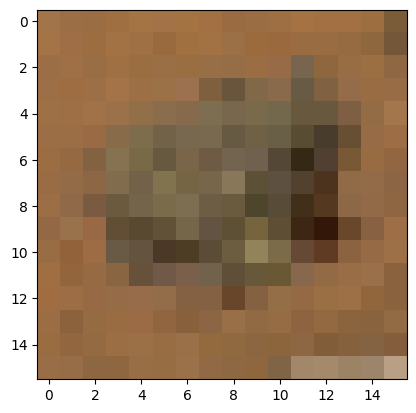

Size :torch.Size([3, 16, 16])
Original size :torch.Size([3, 32, 32])


In [24]:
img_pool=p(img[0])
imshow(img_pool)
print(f'Size :{img_pool.shape}')
print(f'Original size :{img[0].shape}')

## 4. Neural network with convolutional layers

The typical structure is **convolution -pooling -nonlinear** function. Such blocks may repeat. After them the dimensions (except batch) are flatened. Then Linear layers with non-linear functionas are applied

[6] https://www.datacamp.com/tutorial/introduction-to-convolutional-neural-networks-cnns

Look also for interactive simulation of Convolutional Network similar to this one:

[7] A.Karpathy ConvNetJS, Classify CIFAR-10 with Convolutional Neural Network   https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html author current webpage: https://karpathy.ai/

Folowing code is only for exercises for higher grade (see instruction at the end) 

In [25]:
from icecream import ic

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(??, 100)#??
        self.fc2 = nn.Linear(??, 10)#??

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #ic('After pool',x.shape)#print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #ic(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


net2 = Net2()
x=img[0] # Assume you run the block with dowloading CIFAR / creation of dataset object, just before "chapter pooling layer" 
print(x.shape) #you may use this command in above forward to check x size at respective point
y=net2(img) #whole batch is an input
print(y.shape)
print(y)

SyntaxError: invalid syntax (1178630082.py, line 8)

Training code for above network. To simplify - make train shorter, we are using `k` as a subsampling of dataset (make it smaller)

In [26]:
k=0.1# make smaller set , one epoch need ca 15 min
train_size = int(k* 0.5 * len(trainset))
validation_size =int(k*len(trainset)) - train_size
train_data, validation_data ,other= torch.utils.data.random_split(trainset, [train_size, validation_size,len(trainset)-train_size-validation_size])
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=1, shuffle=True)
epochs=5


In [27]:
def training2(net,criterion,optimizer,epochs,train_dataloader,validation_dataloader,test_dataloader):

    #for figure only
    train_err=[]
    valid_err=[]
    test_err=[]

    for epoch in range(epochs):  # loop over the dataset multiple times
        train_err__=0.0
        valid_err__ =0.0
        running_loss = 0.0

        valid_iterator=iter(validation_dataloader)
        for i, data in enumerate(train_dataloader):

            #Training
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            #inputs=torch.Tensor.new_tensor(inputs,dtype=torch.double)
            #torch.tensor(inputs,dtype=torch.double)
            inputs=inputs.float()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_err__+=running_loss
            print(f'[{epoch + 1}, {i + 1:5d}] training loss: {running_loss:.3f}') # /10 =num minibatches
            running_loss = 0.0
            #if i % 10 == 9:    # print every 10 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #    running_loss = 0.0

            #validation
            with torch.no_grad():
                inputs, labels = next(valid_iterator) # on some versions: inputs, labels = valid_iterator.next()
                outputs = net(inputs.float())
                loss = criterion(outputs, labels)
                valid_err__+=loss.item()
                print(f'[{epoch + 1}, {i + 1:5d}] validation loss: {loss.item() :.3f}')


        train_err.append(train_err__)
        valid_err.append(valid_err__)

        with torch.no_grad():
            running_loss = 0.0
            for data in test_dataloader:
                inputs, labels =data
                outputs = net(inputs.float())
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        test_err.append(running_loss)
        print(f'test loss: {running_loss /len(test_data):.3f}')
    print('Finished Training')
    #print(f'train_err: {train_err}  valid_err:{valid_err} test_err:{test_err}')
    return train_err,valid_err,test_err

In [28]:
criterion = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = optim.SGD(net2.parameters(), lr=0.1)#, momentum=0.9)

train_err,valid_err,test_err=training2(net2,criterion,optimizer,epochs,train_dataloader,validation_dataloader,testloader)

NameError: name 'net2' is not defined

In [ ]:
plt.plot(np.arange(1,epochs+1),np.array(train_err),'b') #ForCrossEntropyLoss we need to use exp, since it is a logarithm function
plt.plot(np.arange(1,epochs+1),np.array(valid_err),'g')
plt.plot(np.arange(1,epochs+1),np.array(test_err),'r')

### Exercises
Chapter 1

1. Change neural network from point 1.1 to such, which have 2 layers
2. Change nonlinear function from above network to another one
3. Add another 1 or 2 outputs to dataset from point 1.1 -any other function or at least a little bit other expression
4. How you create neural network to calculate Fourier Series (at given order). Note that Fourier Series is weighted sum of predefined base functions

Chapter 2

5. What did you notice on processed image in chapter 2 ?
6. Apply mask for smoothing image.
7. What are the other parameters of Convolutional Layer than shown in chapter 2?
8. Propose and apply mask, which detect edges in another direction.
9. What solution do you propose to detect all edges?

Chapter 3

10. Check the other parameters of pooling layer than shown in chapter 3. How the image will look like?

Chapter 4

11. Fill the numbers in above example. This network can be applied to example https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 

Note that you need to calculate number of inputs after operation flatten - multiply the size on all flatten dimensions (you can debug). Number of outputs of fc1 has to agree with inputs fc2

12. To above exercise add one or more blocks with convolution (you may change stride parameter in pooling layer). Then also number of channels at output of one block with convolution has to agree with input channels to the next block with convolution.

13. Run training for network from ex 11. Describe changes of the loss

**Mandatory exercises** (70% points): Run the code

**Exercises for bigger grade**: 4 exercises required for 100% points for this report.

**Write here, which exercises you did:**


In [10]:
# Exercise 1 - Change neural network from point 1.1 to such, which have 2 layers
class TwoLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 10)  # Pierwsza warstwa, zwiększamy liczbę neuronów
        self.layer2 = nn.Linear(10, 2)  # Druga warstwa
    
    def forward(self, x):
        x = F.relu(self.layer1(x))  # Funkcja aktywacji dla pierwszej warstwy
        x = self.layer2(x)  # Druga warstwa, bez aktywacji
        return x

net = TwoLayerNet()


In [ ]:
#Exercise 2 - Change nonlinear function from above network to another one

class TwoLayerNetTanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 10)
        self.layer2 = nn.Linear(10, 2)
    
    def forward(self, x):
        x = torch.tanh(self.layer1(x))  # Zmiana funkcji aktywacji na tanh
        x = self.layer2(x)
        return x

net = TwoLayerNetTanh()


In [9]:
#exercise 3 - Add another 1 or 2 outputs to dataset from point 1.1 -any other function or at least a little bit other expression

class ExtendedData(Dataset):
    def __init__(self, n_points):
        self.n = n_points
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        x = idx / self.n * 2 * math.pi
        y1 = math.sin(x)
        y2 = math.cos(x)
        y3 = math.sin(2*x)  # Nowa funkcja
        return np.array([x]), np.array([y1, y2, y3])  # Dodatkowe wyjście

full_dataset = ExtendedData(100)


In [8]:
#Exercise 4 -How you create neural network to calculate Fourier Series (at given order). Note that Fourier Series is weighted sum of predefined base functions

class FourierNet(nn.Module):
    def __init__(self, order=5):
        super().__init__()
        self.order = order
        self.linear = nn.Linear(2 * order, 1)  # Liczba parametrów zależy od rzędu szeregu
    
    def forward(self, x):
        features = torch.cat([torch.sin(n*x) for n in range(1, self.order+1)] +
                             [torch.cos(n*x) for n in range(1, self.order+1)], dim=-1)
        output = self.linear(features)
        return output

net = FourierNet(order=5)
